## Using Grammar and Word Lists

It would be nice to clean up a dataset which contains grammatically incorrect language and make it seem more professional. 

To do this we will experiment with numerous open source libraries to determine their efficacy. 

We also want to see if we can replace misspelled words and expand contrations into their correct forms.

Another eventual task will be to determine the 'quality' of a given sentence.

In [23]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from pprint import pprint

%matplotlib inline

### Gather Data Files

In [24]:
!ls /home/brandon/terabyte/Datasets

cornell			      imdb_full.pkl	  ubuntu
cornell_movie_dialogs_corpus  kaggle		  ubuntu_data_wildml.tar.gz
dogscats		      pre_trained_models  vocab10000.to
dogscats.zip		      reddit		  wmt
fucked_up_data		      simple-examples
glove			      test_data


In [25]:
DATA_ROOT = '/home/brandon/terabyte/Datasets/reddit/'
# Determine if this directory exists, if not use Ivan's directory.
if (os.path.isdir(DATA_ROOT)):
    pass
else:
    DATA_ROOT = '/Users/ivan/Documents/sp_17/reddit_data'
DATA_YEAR = '2007'
# Use os.path.join; it will figure out the '/' in between.
RAW_DATA_FILES = os.listdir(os.path.join(DATA_ROOT, 'raw_data', DATA_YEAR))
# Always work with full pathnames to be safe.
RAW_DATA_FILES = [os.path.join(DATA_ROOT, 'raw_data', DATA_YEAR, file) for file in RAW_DATA_FILES 
                  if not file.startswith('.')]
pprint(RAW_DATA_FILES)

['/home/brandon/terabyte/Datasets/reddit/raw_data/2007/RC_2007-10',
 '/home/brandon/terabyte/Datasets/reddit/raw_data/2007/RC_2007-11',
 '/home/brandon/terabyte/Datasets/reddit/raw_data/2007/RC_2007-12']


### Load Data

In [26]:
def load_data():
    df = pd.read_json(RAW_DATA_FILES[0], lines=True)
    init_num_rows = len(df)
    print("Number of lines in raw data file", init_num_rows)
    pprint("Column names from raw data file:")
    pprint(df.columns)
    return df

In [27]:
df = load_data()

Number of lines in raw data file 150429
'Column names from raw data file:'
Index(['archived', 'author', 'author_flair_css_class', 'author_flair_text',
       'body', 'controversiality', 'created_utc', 'distinguished', 'downs',
       'edited', 'gilded', 'id', 'link_id', 'name', 'parent_id',
       'retrieved_on', 'score', 'score_hidden', 'subreddit', 'subreddit_id',
       'ups'],
      dtype='object')


In [28]:
def show_len_update(df):
    print("Now there are", len(df), "rows.")
    
def root_comments(df):
    '''Build list determining which rows of df are root comments.
    
    Returns: 
        list of length equal to the number of rows in our data frame. 
    '''
    root_value = []
    # Iterate over DataFrame rows as namedtuples, with index value as first element of the tuple.
    for row in df.itertuples():
        root_value.append(row.parent_id == row.link_id)
    return root_value

def random_rows_generator(num_rows_per_print, num_rows_total):
    num_iterations = num_rows_total // num_rows_per_print 
    shuffled_indices = np.arange(num_rows_per_print * num_iterations)
    np.random.shuffle(shuffled_indices)
    for batch in shuffled_indices.reshape(num_iterations, num_rows_per_print):
        yield batch
        
#rand_rows = random_rows_generator(4, len(df))

### Initial Clean up

* Start by removing comments without a body (deleted).
* Remove comments larger than 150 words long.
* Remove unneccesary columns. 
* Add a column determining whether a row is a root comment.

In [29]:
def initial_clean(df):
    df['root'] = root_comments(df)
    df = df[['author', 'body', 'link_id', 'parent_id', 'name', 'root', 'subreddit']]
    df.style.set_properties(subset=['body'], **{'width': '500px'})
    df.style.set_properties(**{'text-align': 'left'})
    show_len_update(df)
    df.head()
    return df

In [30]:
df = initial_clean(df)

Now there are 150429 rows.


In [31]:
df.head()

,author,body,link_id,parent_id,name,root,subreddit
0,bostich,test,t3_5yba3,t3_5yba3,t1_c0299an,True,reddit.com
1,igiveyoumylife,much smoother.\r\n\r\nIm just glad reddit is b...,t3_5yba3,t3_5yba3,t1_c0299ao,True,reddit.com
2,Arve,"Can we please deprecate the word ""Ajax"" now? \...",t3_5yba3,t1_c02999p,t1_c0299ap,False,reddit.com
3,[deleted],[deleted],t3_5yba3,t3_5yba3,t1_c0299aq,True,reddit.com
4,gigaquack,"Oh, I see. Fancy schmancy ""submitting....""",t3_5yba3,t1_c0299ah,t1_c0299ar,False,reddit.com


In [32]:
modify_list = [('\r\n', ' '),
               ('\n', ' '),
               ('\r', ' '),
               ('&gt;', ' '),
               ('&lt;', ' '),
               ('/__|\*|\#|(?:\[([^\]]*)\]\([^)]*\))/gm', '[link]'),
               ('https?:\/\/(?:www\.|(?!www))[^\s\.]+\.[^\s]{2,}|www\.[^\s]+\.[^\s]{2,}', '[link]'),
               ('\d+', 'NUMBER'),
               ('\[', ''),
               ('\]', ''),
               ('\/\/', ''),
               ('\.\.\.', '. ')
              ]

modify_value = {'\r\n': 1,
               '\n': 1,
               '\r': 1,
               '&gt;': 10,
               '&lt;': 10,
               '/__|\*|\#|(?:\[([^\]]*)\]\([^)]*\))/gm': 100,
               'https?:\/\/(?:www\.|(?!www))[^\s\.]+\.[^\s]{2,}|www\.[^\s]+\.[^\s]{2,}': 100,
               '\d+': 1000,
               '\[': 10000,
               '\]': 10000,
               '\/\/': 10000,
               '\.\.\.': 100000
              }

In [33]:
def clean_with_tracking(df):
    df = df.loc[df.body != '[deleted]'].reset_index(drop=True)
    df.style.set_properties(subset=['body'], **{'width': '800px'})
    df['body'] = df['body'].map(lambda s: s.strip().lower())
    
    total_mods = {}
    if 'mods' not in df: 
        df['mods'] = np.zeros(len(df['body']), dtype=int)
    for patrn in modify_list:
        new_df = df['body'].replace({patrn[0]: patrn[1]}, regex=True, inplace=False)
        modifications = list((np.where(new_df.values != df['body'].values))[0])
        df['body'] = new_df
        df['mods'][modifications] += modify_value[patrn[0]]
        total_mods[patrn[0]] = len(modifications)
    return df, total_mods

In [34]:
df,total_mods = clean_with_tracking(df)

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [35]:
df.tail()

,author,body,link_id,parent_id,name,root,subreddit,mods
126315,folderol,muscle memory. or he never knew how to run a...,t3_5zj73,t1_c02cfl4,t1_c02cheo,False,reddit.com,100001
126316,michaelco,man develops delusions wow thats a headline,t3_5zjx2,t3_5zjx2,t1_c02chep,True,reddit.com,0
126317,aletoledo,i have a list of redditers i wish to have cens...,t3_5zk1h,t1_c02che2,t1_c02cher,False,reddit.com,1
126318,Dark-Star,nope. too lazy and don't care for until they o...,t3_5zimk,t1_c02cebw,t1_c02ches,False,politics,120101
126319,M0b1u5,us: we are fucking idiots.,t3_5zep2,t3_5zep2,t1_c02cheu,True,politics,0


## pyEnchant is used to check if this is a real word.

* An issue with this apporach is words that are not english, but are used heavily (e.g. 'reddit')

In [36]:
import enchant
d = enchant.Dict("en_US")

In [37]:
[(d.check(word), word) for word in df.body[1].split()]

[(True, 'much'),
 (True, 'smoother.'),
 (False, 'im'),
 (True, 'just'),
 (True, 'glad'),
 (False, 'reddit'),
 (True, 'is'),
 (False, 'back,'),
 (False, 'linkreddit'),
 (True, 'in'),
 (False, 'mirc'),
 (True, 'was'),
 (True, 'entertaining'),
 (True, 'but'),
 (True, 'i'),
 (True, 'had'),
 (True, 'no'),
 (True, 'idea'),
 (True, 'how'),
 (True, 'addicted'),
 (True, 'i'),
 (True, 'had'),
 (True, 'become.'),
 (True, 'thanks'),
 (True, 'for'),
 (True, 'making'),
 (True, 'the'),
 (True, 'detox'),
 (True, 'somewhat'),
 (True, 'short.')]

In [38]:
import language_check

ImportError: No module named 'language_check'

In [ ]:
tool = language_check.LanguageTool('en_US')

In [ ]:
matches = tool.check(df.body[1])

In [ ]:
tool.disabled.add("UPPERCASE_SENTENCE_START")
tool.disabled.add('I_LOWERCASE')

In [ ]:
matches = tool.check(df.body[1])

### Remove comments with more than n words

In [ ]:
def remove_large_comments(n, df):
    print("Length before:", df['body'].size)
    df = df[df['body'].map(lambda s: len(s.split(' '))) < n].reset_index(drop=True)
    show_len_update(df)
    return df

### Using the tokenizer from io_utils


In [ ]:
import re
_WORD_SPLIT = re.compile("([.,!?\"':;)(])")
_DIGIT_RE   = re.compile(r"\d")

def basic_tokenizer(sentence):
    """Very basic tokenizer: split the sentence into a list of tokens."""
    words = []
    for space_separated_fragment in sentence.strip().split():
        words.extend(_WORD_SPLIT.split(space_separated_fragment))
    return [w for w in words if w]

In [ ]:
# 
df['body'] = [basic_tokenizer(sentence) for sentence in df['body']]

In [ ]:
df['body']

In [ ]:
a= [word for sentence in df['body'].values for word in sentence]
a

In [ ]:
#source : http://stackoverflow.com/questions/33093809/count-the-frequency-of-elements-in-list-of-lists-in-python/33093930
from itertools import chain
from collections import Counter
a= [word for sentence in df['body'].values for word in sentence]
word_freq = Counter(chain(a))
sorted_word_freq = sorted(word_freq.items(), key=lambda x: -x[1])

### Number of words used

In [ ]:
sum([value for key, value in word_freq.items()])

### Number of 'valid' words

In [ ]:
sum([value for key, value in word_freq.items() if d.check(key)])

In [ ]:
show_len_update(df)

### We want to know how many sentences we have if we remove all senteces with invalid words.

In [ ]:
def invalid_word(df):
    '''Goes through the content and determines whether an invalid word is 
    present.
    
    The data frame should provide a body field which will be inspected.
    '''
    d = enchant.Dict("en_US") 
    valid_sentences = [True] * len(df)
    misspelled_words = {}
     
    for idx, sentence in enumerate(df['body'].values):
        for word in sentence:
            if not d.check(word):
                if word in misspelled_words:
                    misspelled_words[word] += 1
                else:
                    misspelled_words[word] = 1
                valid_sentences[idx] = False
    print("There are %i valid sentences out of %i." % (sum(valid_sentences), len(valid_sentences)))
    print("There are %i misspelled words." % len(misspelled_words))
    return valid_sentences, misspelled_words

In [ ]:
valid_sent, misspelled = invalid_word(df)

In [ ]:
print('Total number of valid sentences using basic english dictionary:')
print(sum(valid_sent))


In [ ]:
df['spell'] = valid_sent

In [ ]:
# We use this list to append some words to our dictionary.
sorted_mispelled_words = sorted(misspelled.items(), key=lambda x: -x[1])

### We write to a text-file the 1000 most common misspelled words

In [ ]:
MISSPELLED_WORDS = '/Users/ivan/Desktop/mywords.txt'
f = open(MISSPELLED_WORDS, 'w')
for word in sorted_mispelled_words[:1000]:
    f.write(word[0] + "\n")
f.close()

In [ ]:
sorted_mispelled_words[:5000]

### Try and replace contractions

In [ ]:
def reset(df):
    df = load_data()
    df = initial_clean(df)
    df,total_mods = clean_with_tracking(df)
    df = remove_large_comments(60, df)
    df = contraction_replacer(df)
    return df

In [ ]:
contractions = { 
        "ain't": "am not",
        "aren't": "are not",
        "can't": "cannot",
        "can't've": "cannot have",
        "'cause": "because",
        "could've": "could have",
        "couldn't": "could not",
        "couldn't've": "could not have",
        "didn't": "did not",
        "doesn't": "does not",
        "don't": "do not",
        "hadn't": "had not",
        "hadn't've": "had not have",
        "hasn't": "has not",
        "haven't": "have not",
        "he'd": "he had",
        "he'd've": "he would have",
        "he'll": "he shall",
        "he'll've": "he shall have",
        "he's": "he has",
        "how'd": "how did",
        "how'd'y": "how do you",
        "how'll": "how will",
        "how's": "how has",
        "I'd": "I had",
        "I'd've": "I would have",
        "I'll": "I shall",
        "I'll've": "I shall have",
        "I'm": "I am",
        "I've": "I have",
        "isn't": "is not",
        "it'd": "it had",
        "it'd've": "it would have",
        "it'll": "it shall",
        "it'll've": "it shall have",
        "it's": "it has",
        "let's": "let us",
        "ma'am": "madam",
        "mayn't": "may not",
        "might've": "might have",
        "mightn't": "might not",
        "mightn't've": "might not have",
        "must've": "must have",
        "mustn't": "must not",
        "mustn't've": "must not have",
        "needn't": "need not",
        "needn't've": "need not have",
        "o'clock": "of the clock",
        "oughtn't": "ought not",
        "oughtn't've": "ought not have",
        "shan't": "shall not",
        "sha'n't": "shall not",
        "shan't've": "shall not have",
        "she'd": "she had",
        "she'd've": "she would have",
        "she'll": "she shall",
        "she'll've": "she shall have",
        "she's": "she has",
        "should've": "should have",
        "shouldn't": "should not",
        "shouldn't've": "should not have",
        "so've": "so have",
        "so's": "so as",
        "that'd": "that would",
        "that'd've": "that would have",
        "that's": "that has",
        "there'd": "there had",
        "there'd've": "there would have",
        "there's": "there has",
        "they'd": "they had",
        "they'd've": "they would have",
        "they'll": "they shall",
        "they'll've": "they shall have",
        "they're": "they are",
        "they've": "they have",
        "to've": "to have",
        "wasn't": "was not",
        "we'd": "we had",
        "we'd've": "we would have",
        "we'll": "we will",
        "we'll've": "we will have",
        "we're": "we are",
        "we've": "we have",
        "weren't": "were not",
        "what'll": "what shall",
        "what'll've": "what shall have",
        "what're": "what are",
        "what's": "what has",
        "what've": "what have",
        "when's": "when has",
        "when've": "when have",
        "where'd": "where did",
        "where's": "where has",
        "where've": "where have",
        "who'll": "who shall",
        "who'll've": "who shall have",
        "who's": "who has",
        "who've": "who have",
        "why's": "why has",
        "why've": "why have",
        "will've": "will have",
        "won't": "will not",
        "won't've": "will not have",
        "would've": "would have",
        "wouldn't": "would not",
        "wouldn't've": "would not have",
        "y'all": "you all",
        "y'all'd": "you all would",
        "y'all'd've": "you all would have",
        "y'all're": "you all are",
        "y'all've": "you all have",
        "you'd": "you had",
        "you'd've": "you would have",
        "you'll": "you shall",
        "you'll've": "you shall have",
        "you're": "you are",
        "you've": "you have"
        }

In [ ]:
def contraction_replacer(df):
    for patrn in contractions.items():
        df['body'].replace({patrn[0]: patrn[1]}, regex=True, inplace=True)    
    return df

In [ ]:
df = contraction_replacer(df)

In [ ]:
df['body'] = [basic_tokenizer(sentence) for sentence in df['body']]

In [ ]:
show_len_update(df)

In [ ]:
valid_sentences, misspelled_words = invalid_word(df)

In [ ]:
sorted_misspelled_words = sorted(misspelled_words.items(), key=lambda x: -x[1])

In [ ]:
sorted_misspelled_words[]

In [ ]:
MISSPELLED_WORDS = '/Users/ivan/Desktop/mywords.txt'
f = open(MISSPELLED_WORDS, 'w')
for word in sorted_mispelled_words[:10000]:
    f.write(word[0] + "\n")
f.close()

In [ ]:
def invalid_word_modified(df):
    '''Goes through the content and determines whether an invalid word is 
    present.
    
    The data frame should provide a body field which will be inspected.
    '''
    d = enchant.DictWithPWL("en_US", MISSPELLED_WORDS)
    valid_sentences = [True] * len(df)
    misspelled_words = {}
     
    for idx, sentence in enumerate(df['body'].values):
        for word in sentence:
            if not d.check(word):
                if word in misspelled_words:
                    misspelled_words[word] += 1
                else:
                    misspelled_words[word] = 1
                valid_sentences[idx] = False
    print("There are %i valid sentences out of %i." % (sum(valid_sentences), len(valid_sentences)))
    print("There are %i misspelled words." % len(misspelled_words))
    return valid_sentences, misspelled_words

In [ ]:
valid_sentences, misspelled_words = invalid_word_modified(df)
sorted_misspelled_words = sorted(misspelled_words.items(), key=lambda x: -x[1])

##### By adding 10000 extra words (not in the original dictionary) we only see 5000 more valid sentences

* Define a threshold which keeps sentences with many of the misspelled words
* For words that are in the original dictionary add 0 points. 
* Words that are not in the original dictionary add the inverse of the number of occurences in the corpus
* We then normalize to the length of the sentence.

In [39]:
df = reset(df)

Number of lines in raw data file 150429
'Column names from raw data file:'
Index(['archived', 'author', 'author_flair_css_class', 'author_flair_text',
       'body', 'controversiality', 'created_utc', 'distinguished', 'downs',
       'edited', 'gilded', 'id', 'link_id', 'name', 'parent_id',
       'retrieved_on', 'score', 'score_hidden', 'subreddit', 'subreddit_id',
       'ups'],
      dtype='object')
Now there are 150429 rows.


/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Length before: 126320
Now there are 102363 rows.


In [40]:
sentences = [basic_tokenizer(sentence) for sentence in df['body']]
words= [word for sentence in sentences for word in sentence]

In [41]:
word_freq = Counter(chain(words))
sorted_word_freq = sorted(word_freq.items(), key=lambda x: -x[1])

In [42]:
def sentence_score(sentence):
    d = enchant.Dict('en_US')
    word_count = len(sentence)
    score = 0
    for word in sentence:
        if not d.check(word):
            try: 
                score = score + 1.0/word_freq[word]
            except ZeroDivisionError:
                score = score + 1.0
    try:
        return score / word_count
    except ZeroDivisionError:
        return 1

In [43]:
def add_sentence_scores(df):
    scores = []
    for sentence in df.body:
        scores.append(sentence_score(basic_tokenizer(sentence)))
    df['score'] = scores

In [44]:
add_sentence_scores(df)

(0, 0.2)

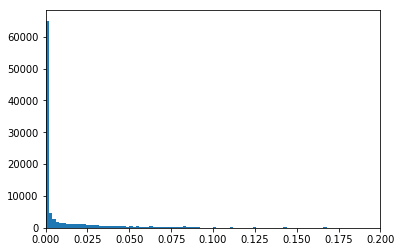

In [45]:
# A plot which displays the distribution of "penalty score" of a sentence. 
plt.hist(df.score.values, bins=500)
plt.xlim(0, 0.2)

In [46]:
len(df.loc[df.score < 0.005])

71194

In [47]:
def load_data():
    df = pd.read_json(RAW_DATA_FILES[0], lines=True)
    df2 = pd.read_json(RAW_DATA_FILES[1], lines=True)
    df3 = pd.read_json(RAW_DATA_FILES[2], lines=True)
    df = df.append(df2, ignore_index=True)
    df = df.append(df3, ignore_index=True)
    df = df.reset_index(drop=True)
    init_num_rows = len(df)
    print("Number of lines in raw data file", init_num_rows)
    pprint("Column names from raw data file:")
    pprint(df.columns)
    return df

In [48]:
df = reset(df)

Number of lines in raw data file 886802
'Column names from raw data file:'
Index(['archived', 'author', 'author_flair_css_class', 'author_flair_text',
       'body', 'controversiality', 'created_utc', 'distinguished', 'downs',
       'edited', 'gilded', 'id', 'link_id', 'name', 'parent_id',
       'retrieved_on', 'score', 'score_hidden', 'subreddit', 'subreddit_id',
       'ups'],
      dtype='object')
Now there are 886802 rows.


/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Length before: 707894
Now there are 580784 rows.


In [49]:
len(df)

580784

In [50]:
sentences = [basic_tokenizer(sentence) for sentence in df['body']]
words= [word for sentence in sentences for word in sentence]

In [51]:
word_freq = Counter(chain(words))
sorted_word_freq = sorted(word_freq.items(), key=lambda x: -x[1])

In [52]:
add_sentence_scores(df)

In [53]:
df.head()

,author,body,link_id,parent_id,name,root,subreddit,mods,score
0,bostich,test,t3_5yba3,t3_5yba3,t1_c0299an,True,reddit.com,0,0.000000
1,igiveyoumylife,"much smoother. im just glad reddit is back, l...",t3_5yba3,t3_5yba3,t1_c0299ao,True,reddit.com,20101,0.007132
2,Arve,"can we please deprecate the word ""ajax"" now? ...",t3_5yba3,t1_c02999p,t1_c0299ap,False,reddit.com,1,0.001079
3,gigaquack,"oh, i see. fancy schmancy ""submitting. .""",t3_5yba3,t1_c0299ah,t1_c0299ar,False,reddit.com,100000,0.027779
4,Percept,testing .,t3_5yba3,t3_5yba3,t1_c0299as,True,reddit.com,100000,0.000000


(0, 0.2)

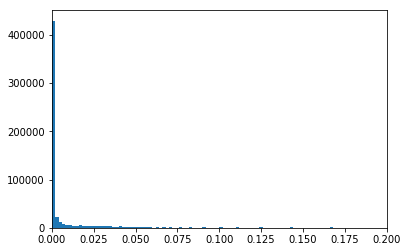

In [54]:
plt.hist(df.score.values, bins=500)
plt.xlim(0, 0.2)

In [55]:
len(df.loc[df.score < 0.005])

457516

In [56]:
## Returns a dictionary with keys being the root comments and values being their immediate children.
## Assumes to have a 'root' column already

## Go through all comments, if it is a root skip it since they wont have a parent_id corresponding
## to a comment.
## 
def children_dict(df):
    children = {}
    for row in df.itertuples():
        if row.root == False:
            if row.parent_id in children.keys():
                children[row.parent_id].append(row.name)
            else:
                children[row.parent_id] = [row.name]
    return children

In [57]:
## Return a dictionary with name being the key and body being the value. 
values_dict = pd.Series(df.body.values, index=df.name).to_dict()

In [58]:
children = children_dict(df)

In [59]:
print('done')

done
